# Week 6 - Classification models  

## Part 4: Travel mode choice - Hierarchical models

This part is where we start to make things more interesting :-)

We will revisit the original real world problem of travel model choice (with 4 classes), but this time we shall consider a hierarchical model. 

More on that later, for now the same stuff from part 2: imports, loading data, preprocessing, train/test split, etc.

Import required libraries:

In [9]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils

import torch

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import config_enumerate, MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Load data:

In [2]:
# load csv
df = pd.read_csv("modechoice_data.csv")
df.head()

,Unnamed: 0,individual,hinc,psize,ttme_air,invc_air,invt_air,gc_air,ttme_train,invc_train,invt_train,gc_train,ttme_bus,invc_bus,invt_bus,gc_bus,invc_car,invt_car,gc_car,mode_chosen
0,0,70.0,30.0,4.0,10.0,61.0,80.0,73.0,44.0,24.0,350.0,77.0,53.0,19.0,395.0,79.0,4.0,314.0,52.0,1.0
1,1,8.0,15.0,4.0,64.0,48.0,154.0,71.0,55.0,25.0,360.0,80.0,53.0,14.0,462.0,84.0,4.0,351.0,57.0,2.0
2,2,62.0,35.0,2.0,64.0,58.0,74.0,69.0,30.0,21.0,295.0,66.0,53.0,24.0,389.0,83.0,7.0,315.0,55.0,2.0
3,3,61.0,40.0,3.0,45.0,75.0,75.0,96.0,44.0,33.0,418.0,96.0,53.0,28.0,463.0,98.0,5.0,291.0,49.0,1.0
4,4,27.0,70.0,1.0,20.0,106.0,190.0,127.0,34.0,72.0,659.0,143.0,35.0,33.0,653.0,104.0,44.0,592.0,108.0,1.0


Preprocess data:

In [3]:
# separate between features/inputs (X) and target/output variables (y)
mat = df.values
X = mat[:,2:-1]
print(X.shape)
y = mat[:,-1].astype("int")
print(y.shape)
ind = mat[:,1].astype("int")
print(ind.shape)

(394, 17)
(394,)
(394,)


In [4]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

Train/test split:

In [5]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 260
num test: 134


Our baseline logistic regression model from sklearn:

In [6]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [2 2 4 4 4 2 4 1 4 4 4 3 1 4 2 1 4 2 1 4 4 4 4 4 2 4 1 4 1 2 4 4 4 2 3 4 4
 3 2 4 4 4 2 2 2 4 1 3 2 3 1 2 4 1 1 4 2 4 4 1 3 2 4 2 4 4 4 3 2 3 2 4 2 4
 4 4 1 4 2 2 4 4 1 4 3 4 4 2 1 4 3 1 4 2 1 4 1 4 4 4 1 1 2 1 3 2 4 4 4 4 4
 4 4 1 3 3 1 4 3 2 4 1 4 2 1 3 2 2 2 4 4 4 4 2]
true values: [4 2 2 4 4 2 1 2 4 4 4 4 1 2 2 1 3 4 1 2 4 3 1 4 2 4 2 1 3 2 4 4 4 4 2 1 1
 3 2 1 4 2 2 2 4 1 1 3 2 3 1 2 4 4 1 4 2 4 4 3 3 4 4 4 4 1 1 3 2 1 2 4 2 4
 4 4 1 2 4 2 4 4 1 4 3 1 4 4 1 4 3 1 1 2 4 4 4 4 4 1 4 3 3 1 3 2 4 4 4 1 4
 4 4 1 4 1 1 4 3 2 1 1 4 2 4 1 2 4 2 1 1 1 4 4]
Accuracy: 0.6194029850746269


## Hierarchical logistic regression in STAN

We will now implement a hierarchical logistic regression. The motivation is actually quite simple. Our dataset consists of multiple observations from various individuals. However, when we build our original logistic regression in STAN, our specification assumes that all individuals share a unique set of bias (alpha) coefficients (beta). In other words, this is equivalent to assuming, for example, that all individuals are equally biased towards a given mode (e.g. car). This is obviously a very strong assumption, right? We should allow different individuals to have different biases (alpha). (We could also consider different coefficients per individual, but for the sake of simplicy, we will just focus on the bias parameters)

This can be done by placing a hierarchical prior on the intercepts (alpha). The generative process then becomes:

1. For each class $c \in \{1,\dots,C\}$
    2. Draw global intercept mean $\mu_c \sim \mathcal{N}(0,10)$
    3. Draw global intercept variance $\sigma_c \sim \mbox{Cauchy}(0,10)$
    5. Draw coefficients $\boldsymbol\beta_c \sim \mathcal{N}(\textbf{0},10 \, \textbf{I})$ (this the same as before...)
    6. For each individual $i \in \{1,\dots,I\}$
        4. Draw $\alpha_{i,c}$ such that $\alpha_{i,c} \sim \mathcal{N}(\mu_c,\sigma_c)$

6. For each data point $n=\{1,\dots,N\}$
    7. Draw target class $y_n \sim \mbox{Multinomial}(\mbox{Softmax}(\textbf{x}_n,\boldsymbol\alpha_{i_n},\boldsymbol\beta_1,\dots,\boldsymbol\beta_C))$
    
where $i_n$ is the individual identifier for person $n$, and $\boldsymbol\mu=\{\mu_1\dots\mu_C\}$ and $\boldsymbol\sigma=\{\sigma_1\dots\sigma_C\}$.

Notice that now, instead of a single intercept per class $\alpha_c$ for all individual, we now have a vector of intercepts $\boldsymbol\alpha_c$ for each class $c$: one intercept parameter per individual! However, all these intercept share a global (population-level) prior.

Lets try to implement this in STAN. Can you do it? :-) 

In [8]:
# define Stan model
model_definition = """
data {
  int<lower=0> N;      // shape of data
  int<lower=0> D;      // dimensions of x
  int<lower=0> C;      // number of possible choices
  int<lower=0> I;      //
  int          ind[N]; //
  matrix[N,D]  X;      // feature matrix
  int          y[N];   // response vector
}
parameters {
  vector[C]     mu_prior;       // global intercept mean 
  real<lower=0> sigma_prior[C]; // global intercept sd 
  matrix[C,I]   alpha;          // intercept  
  matrix[C,D]   beta;           // parameters
}
model{

  // choice parameters
  for (c in 1:C){          
    mu_prior[c]    ~ normal(0,5);
    sigma_prior[c] ~ cauchy(0,5);
    beta[c]        ~ normal(0,10);
    
    // individual parameters (for each class)
    for (i in 1:I){        
      alpha[c,i]   ~ normal(mu_prior[c], sigma_prior[c]);
    }
  }
  
  for (n in 1:N){
    y[n] ~ categorical_logit(alpha[,ind[n]] + beta*X[n]');
  }
}
"""

# compile model
sm = pystan.StanModel(model_code=model_definition)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f8c029f9b59592cf5c4adefff4128296 NOW.


In [29]:
def hierarchical_model(X, n_cat, obs=None):
    n_beta = X.shape[1]
    alpha_mean = pyro.sample("alpha_mean", dist.Normal(0., 5.).expand([n_cat]).to_event(1))  # Prior for the bias mean
    alpha_std  = pyro.sample("alpha_std",  dist.HalfCauchy(5.).expand([n_cat]).to_event(1))  # Prior for the bias standard deviation
    beta  = pyro.sample("beta", dist.Normal(0., 5.).expand([n_beta, n_cat]).to_event(1))     # Priors for the regression coefficents
    
    mu = X.matmul(beta)
    with pyro.plate("data", X.shape[0]):
        alpha = pyro.sample("alpha", dist.Normal(alpha_mean, alpha_std).to_event(1)) # Draw the individual parameter for each individual
        y = pyro.sample("y", dist.Categorical(logits=alpha+mu), obs=obs) # If you use logits you don't need to do sigmoid
        
    return y

In [31]:
n_cat = 4
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()

Prepare input data for STAN, compile STAN program and run inference using ADVI (much faster in this case):

In [32]:
nuts_kernel = NUTS(hierarchical_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
mcmc.run(X_train, n_cat, y_train-1) # Pyro accepts categories starting from 0

Sample: 100%|██████████| 1100/1100 [24:18,  1.33s/it, step size=2.79e-02, acc. prob=0.893]


In [33]:
mcmc.summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
alpha_mean[0]      0.33      3.07      0.71     -4.81      5.95     10.24      1.10
alpha_mean[1]      0.71      2.71      0.66     -2.73      6.04      7.31      1.03
alpha_mean[2]     -2.73      3.03     -2.74     -7.70      2.16      8.10      1.01
alpha_mean[3]     -1.78      3.31     -1.73     -7.39      3.63     68.48      1.00
 alpha_std[0]      3.92      2.59      3.83      0.33      7.80      7.28      1.04
 alpha_std[1]      1.55      0.96      1.22      0.36      2.68      6.07      1.05
 alpha_std[2]      2.25      1.50      2.09      0.37      3.90      9.29      1.12
 alpha_std[3]     38.78     11.78     38.74     16.78     55.16     13.99      1.07
    beta[0,0]      0.89      2.89      0.87     -3.90      5.50    423.08      1.00
    beta[0,1]     -4.27      3.01     -4.18     -9.23      0.82    348.90      1.00
    beta[0,2]     -0.45      2.90     -0.43     -5.75      3.74   1126.64  

In [9]:
# prepare data for Stan model
N, D = X_train.shape
C = int(y_train.max())
I = ind.max()
print("N=%d, D=%d, C=%d, I=%d" % (N,D,C,I))
data = {'N': N, 'D': D, 'C': C, 'I':I, 'ind':ind_train, 'X': X_train, 'y': y_train}

N=260, D=17, C=4, I=80


In [10]:
%%time
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

CPU times: user 7.7 s, sys: 32.7 ms, total: 7.74 s
Wall time: 7.71 s


Lets plot the posterior distributions of some of the parameters of our model (you may have called these variables something else...):

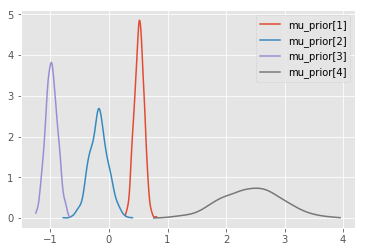

In [11]:
pystan_utils.vb_plot_variables(fit, "mu_prior")

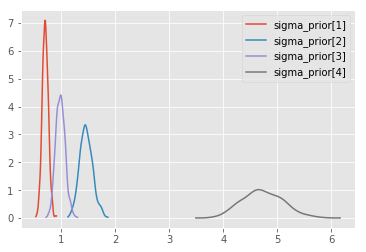

In [12]:
pystan_utils.vb_plot_variables(fit, "sigma_prior")

We can now use the inferred posteriors to make predictions. Lets first use the "pystan_utils" package to extract the expected values of the posterior distribution of the model parameters:

In [13]:
# get fitted parameters
mu_prior = pystan_utils.vb_extract_variable(fit, "mu_prior", var_type="vector")
sigma_prior = pystan_utils.vb_extract_variable(fit, "sigma_prior", var_type="vector")
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="matrix", dims=(C,I))
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="matrix", dims=(C,D))

Using expected values of the parameters, we can make predictions for the testset. However, we need to account for the fact that we now have different bias parameters per-individual, and adapt the code for making predictions accordingly. Make sure that you understand the code below. As always, if something is not 100% clear, ask! :-)

In [39]:
# Pyro
alpha_mean = mcmc.get_samples()["alpha_mean"]
alpha_std  = mcmc.get_samples()["alpha_std"]
beta = mcmc.get_samples()["beta"]

In [ ]:
# make predictions for test set, this needs to be modified. I don't understand why is it in this way.
y_hat = alpha[:,ind_test-1] + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

In [14]:
# make predictions for test set
y_hat = alpha[:,ind_test-1] + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [2 2 4 4 4 2 1 4 4 4 4 4 1 2 2 1 4 2 1 2 4 3 4 4 2 4 2 1 1 2 4 4 4 2 3 1 1
 3 2 4 4 2 2 2 4 1 1 3 2 3 1 2 4 1 1 4 2 4 4 1 3 4 4 2 4 1 4 3 2 1 2 4 2 4
 4 4 1 4 4 2 4 4 1 4 3 2 4 4 1 4 3 1 1 2 1 4 4 1 4 1 1 4 2 4 3 2 4 4 2 1 4
 2 3 1 3 1 1 4 3 2 3 1 4 2 1 2 2 2 2 1 1 1 4 4]
true values: [4 2 2 4 4 2 1 2 4 4 4 4 1 2 2 1 3 4 1 2 4 3 1 4 2 4 2 1 3 2 4 4 4 4 2 1 1
 3 2 1 4 2 2 2 4 1 1 3 2 3 1 2 4 4 1 4 2 4 4 3 3 4 4 4 4 1 1 3 2 1 2 4 2 4
 4 4 1 2 4 2 4 4 1 4 3 1 4 4 1 4 3 1 1 2 4 4 4 4 4 1 4 3 3 1 3 2 4 4 4 1 4
 4 4 1 4 1 1 4 3 2 1 1 4 2 4 1 2 4 2 1 1 1 4 4]
Accuracy: 0.7761194029850746


Now, that is a signficant improvement, right? We improved the accuracy of our model from 67.9% to about 78.4%! (Hopefully you were able to obtain a similar or even better result :-)

Did you see how your prior knowledge about the problem can make a substantial difference when building a model for it? This is how things are done in the model-based machine learning approach!

Given the posterior distributions inferred by STAN, we can even analyse the biases of different individuals identified by our model:

In [15]:
for i in range(I):
    print(i, alpha[:,i])

0 [ 0.49493799 -0.66547827 -0.97909644  6.05136226]
1 [ 0.61548592 -0.1719418  -1.14377243  1.6775185 ]
2 [ 0.63544016 -0.46592926 -1.11443979  0.05859614]
3 [ 0.64697984  0.06464827 -1.15973146 -1.10694327]
4 [ 0.47826976 -0.9520224  -0.42672376  0.06114656]
5 [ 0.46148417 -0.51199502 -0.63216466  0.44860399]
6 [ 0.18555415 -0.487783   -0.27201526  2.64464214]
7 [ 0.34290118 -0.23219908 -0.64914334  0.02655454]
8 [ 0.53397228 -0.16298139 -0.99478472  0.20757976]
9 [ 0.53292804 -0.6945954  -1.02637797  6.7351566 ]
10 [ 0.75264995 -0.00708048 -1.2262439  -2.05968167]
11 [ 0.41021327  0.17589682 -0.93222552  1.10107654]
12 [ 0.27819668  0.74573304 -1.03130682  4.17635658]
13 [ 0.488279    0.09071233 -0.97708368 -0.05367024]
14 [ 0.5005849   0.0158236  -1.11614501  1.65897884]
15 [ 0.37439161 -0.20181668 -1.03104198  4.52107869]
16 [ 0.52693513  0.07955342 -0.99318259 -0.1993491 ]
17 [ 0.45045254 -0.2883676  -0.94003193  3.4269296 ]
18 [ 0.40943727  0.41636781 -1.08654683  1.26800941]
19 

Perhaps a histogram allows for a better global analysis:

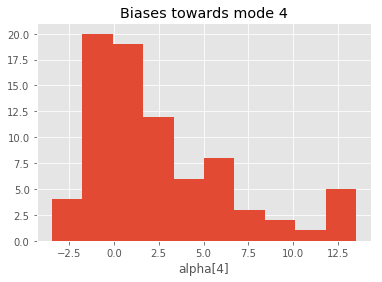

In [16]:
# histogram of biases towards mode 4 (car)
plt.hist(alpha[3,:])
plt.title("Biases towards mode 4")
plt.xlabel("alpha[4]")
plt.show()

We can observe that, for most individuals the biases is around 0. However, we can also see that a few individuals really love their cars!

Reflection exercise: can you think of ways in which you could use this model to try to identify policies (e.g. price changes or making terminals more efficient) that would allow to shift people's travel mode choices away from the car (e.g. towards public transport)?